# IAPR: Project ‒  Coin Counter


**Group ID:** 12

**Author 1 (sciper):** Vray Alexandre (310104)   
**Author 2 (sciper):** Aellen Edgar (311574)  
**Author 3 (sciper):** Robrdet Alexis (371391)   

**Release date:** 26.04.2024  
**Due date:** 29.05.2024 (11:59 pm)

In [1]:
import cv2
import os

import numpy as np
import pandas as pd
import random
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt

from utils.display import plot_images

import skimage

data_folder = 'data/train'
test_folder = 'data/test'

## Read data

In [2]:
def image_type(row):
    id = int(row['id'][5:])
    if 277 <= id <= 323 or 405 <= id <= 454:
        return 0
    elif 325 <= id <= 370 or 462 <= id <= 503:
        return 1
    else:
        return 2



data = pd.read_csv('data/train_labels.csv').sort_values(by='id')
data['type'] = data.apply(image_type, axis=1)

data

id  5CHF  2CHF  1CHF  0.5CHF  0.2CHF  0.1CHF  0.05CHF  2EUR  1EUR  \
6   L1010277     1     0     0       0       0       0        0     1     0   
10  L1010279     0     1     0       1       1       1        0     0     0   
0   L1010281     0     0     0       0       2       3        1     0     0   
15  L1010283     0     0     0       1       0       0        0     1     0   
8   L1010287     0     1     1       0       0       0        1     0     0   
..       ...   ...   ...   ...     ...     ...     ...      ...   ...   ...   
79  L1010515     0     0     0       0       0       1        0     1     0   
74  L1010517     1     0     0       0       0       0        0     1     0   
78  L1010521     1     0     0       0       0       0        0     1     0   
80  L1010523     0     0     0       0       0       0        0     1     1   
76  L1010524     1     0     0       0       0       0        0     0     0   

    0.5EUR  0.2EUR  0.1EUR  0.05EUR  0.02EUR  0.01EUR  OOD  type  
6        1       2       0        0        0        0    0     0  
10       0       0       0        0        0        0    0     0  
0        0       0       0        2        0        0    0     0  
15       2       1       0        1        0        0    0     0  
8        0       0       2        1        1        1    0     0  
..     ...     ...     ...      ...      ...      ...  ...   ...  
79       0       0       0        0        0        0    1     2  
74       0       0       0        0        0        0    1     2  
78       0       0       0        0        0        0    1     2  
80       0       0       0        0        0        0    1     2  
76       1       0       0        0        0        0    1     2  

[81 rows x 18 columns]

In [3]:
def load_images_from_folder(folder):
    images = []
    for root, _, filenames in sorted(os.walk(folder)):
        for filename in sorted(filenames):
            id = int(filename[1:8])
            batch = 2
            if id<batch*18 or id>=(batch+1)*18:
                continue
            img = cv2.imread(os.path.join(root, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
    return np.array(images)

# # Replace 'path_to_your_folder' with the path to the folder containing your images
# x = load_images_from_folder(data_folder)
# y = data.loc[:,'5CHF':'OOD'].values
# types = data['type'].values

# random.seed(42)
# shuffle = random.sample(range(len(x)), k=len(x))
# x = [x[i] for i in shuffle]
# y = y[shuffle]
# types = types[shuffle]

# x_train = x[:int(0.8*len(x))]
# y_train = y[:int(0.8*len(y))]
# types_train = types[:int(0.8*len(types))]

# x_val = x[int(0.8*len(x)):]
# y_val = y[int(0.8*len(y)):]
# types_val = types[int(0.8*len(types)):]

# labels = data.loc[:,'5CHF':'OOD'].columns

x_val = load_images_from_folder(test_folder)

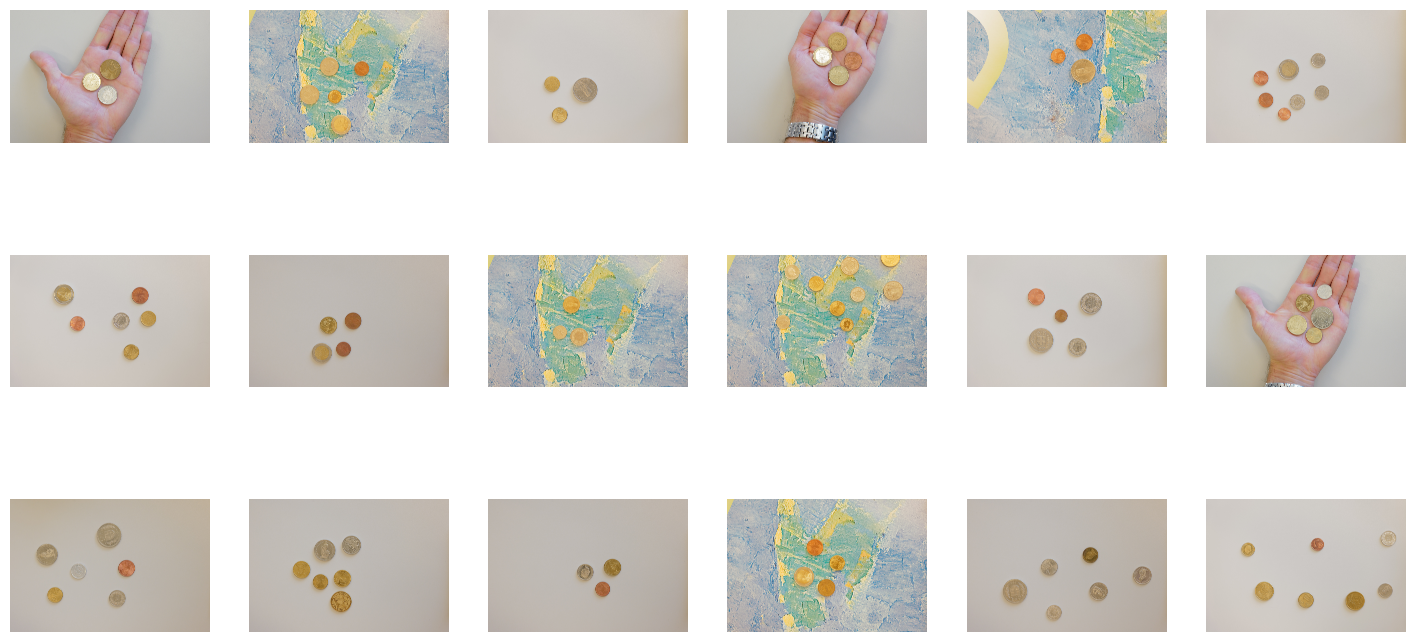

In [4]:
x_sample = x_val #[x_train[i] for i in range(len(x_train)) if types_train[i] == 2] #[x_val[i] for i in range(len(x_val)) if types_val[i] == 2] #
y_sample = [] #y_val #y_train[types_train == 2]#y_val[types_val==2] # 

plot_images(images=x_sample, coins=y_sample)

## 1. Localization

In [5]:
x_sample = [cv2.resize(x_sample[i], (600, 400)) for i in range(len(x_sample))]

In [6]:
# Mean_color = np.zeros((len(x_train),3))
# for i in range(len(x_train)):
#     Mean_color[i,:] = x_train[i].mean(axis=(0,1))

# np.shape(Mean_color)

In [7]:
# fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# axs[0].scatter(Mean_color[:,0], Mean_color[:,1], c=types_train, cmap='viridis')

# sc = axs[1].scatter(Mean_color[:,0], Mean_color[:,1]/Mean_color[:,0], c=types_train, cmap='viridis')

# plt.colorbar(sc)

In [8]:
from utils.utils import remove_overlapping_circles
from utils import morphology

Image 0: Hand
Image 1: Noisy background
Image 2: Neutral background
Image 3: Hand
Image 4: Noisy background
Image 5: Neutral background
Image 6: Neutral background
Image 7: Neutral background
Image 8: Noisy background
Image 9: Noisy background
Image 10: Neutral background
Image 11: Hand
Image 12: Neutral background
Image 13: Neutral background
Image 14: Neutral background
Image 15: Noisy background
Image 16: Neutral background
Image 17: Neutral background


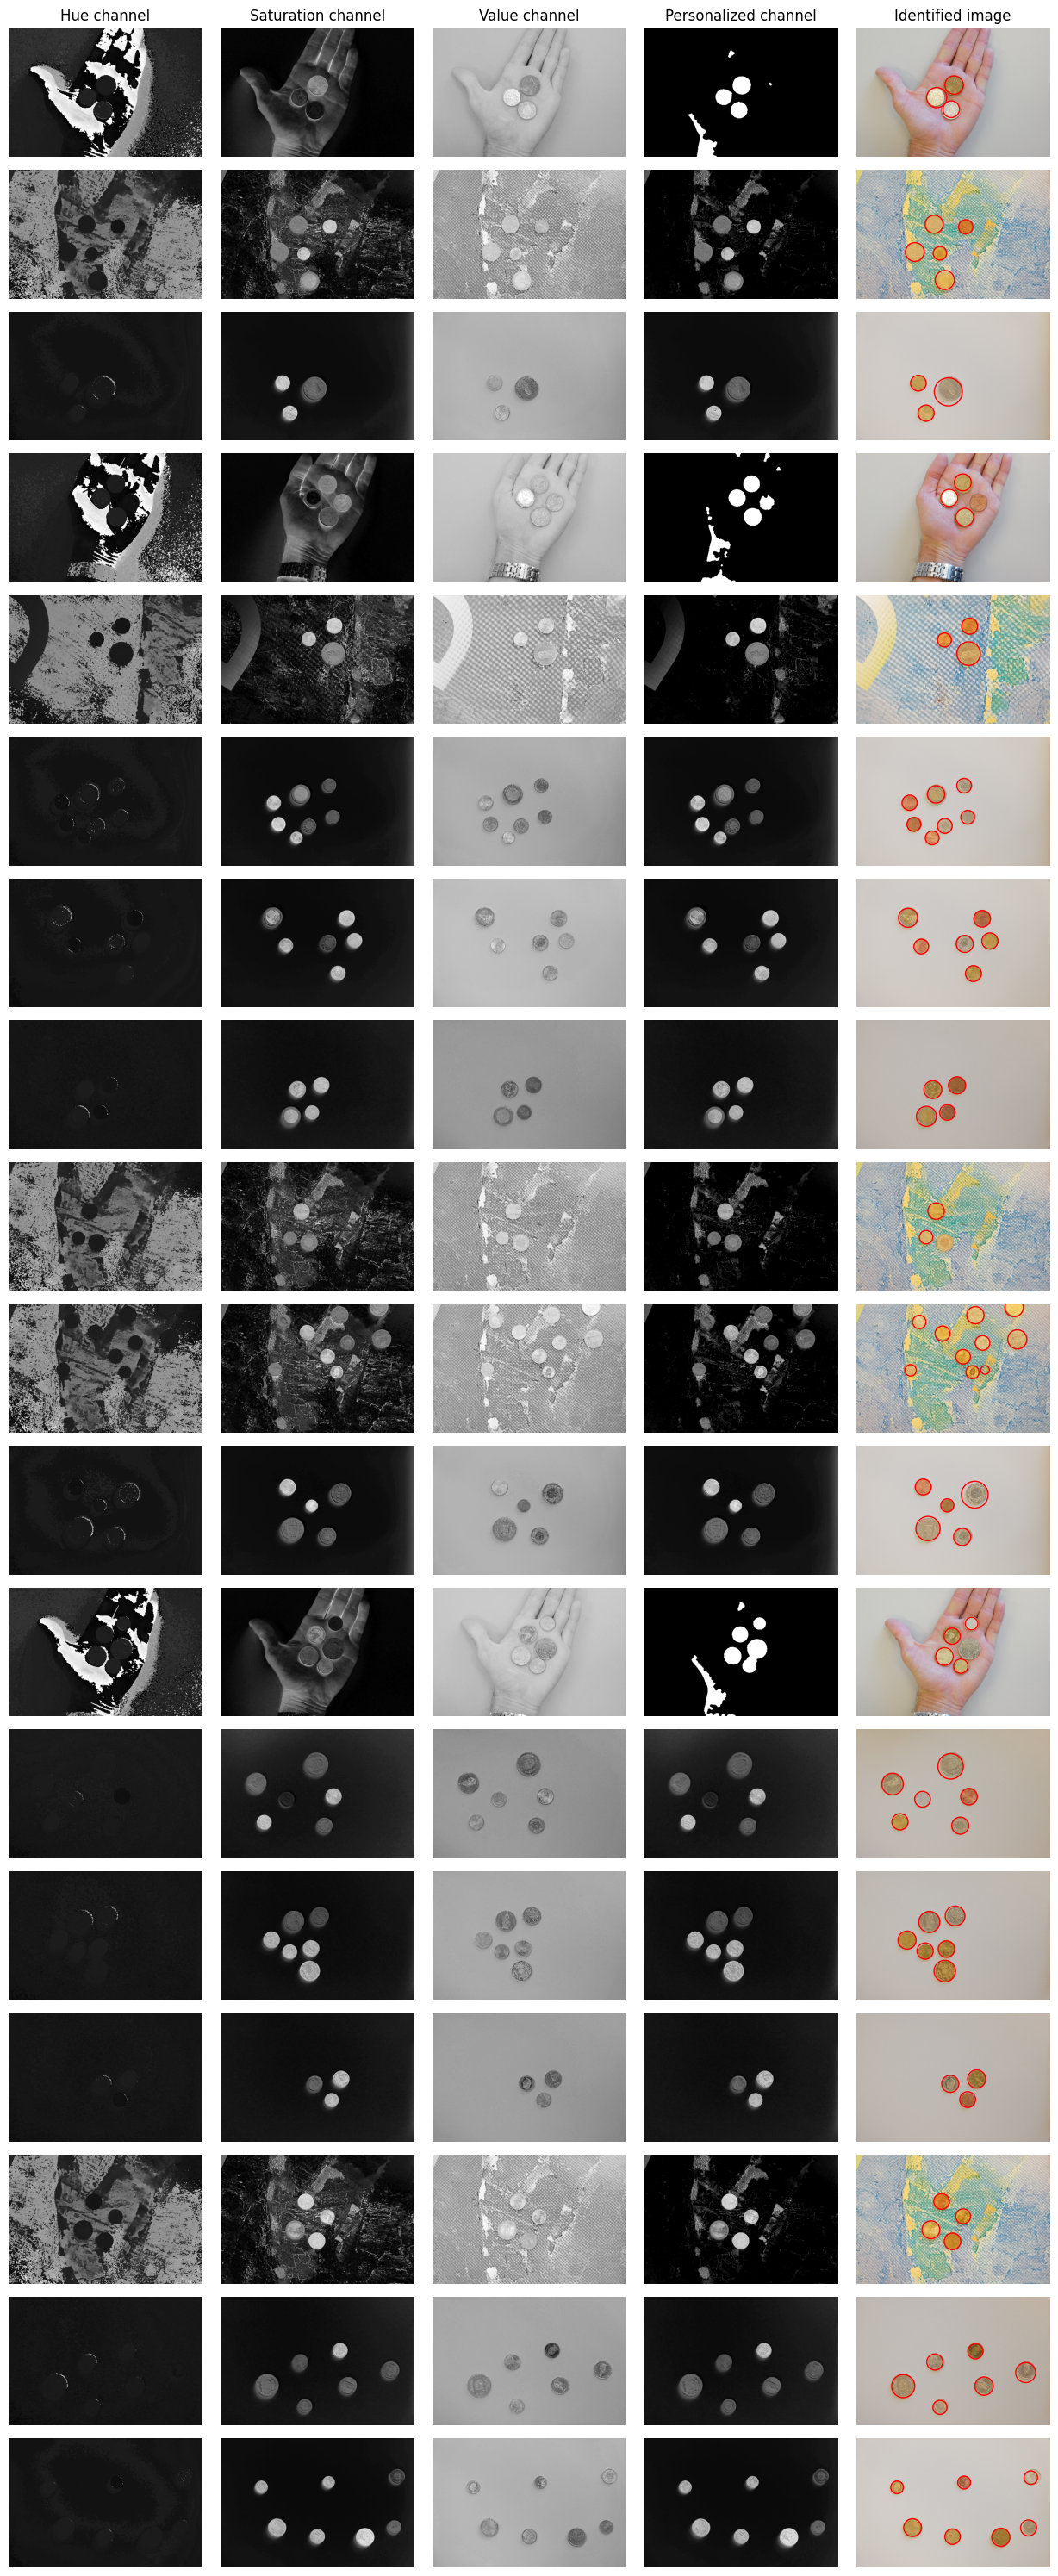

In [9]:
_, axs = plt.subplots(len(x_sample), 5, figsize=(15/6*5,5/3*len(x_sample)))

axs[0,0].set_title('Hue channel')
axs[0,1].set_title('Saturation channel')
axs[0,2].set_title('Value channel')
axs[0,-2].set_title('Personalized channel')
axs[0,-1].set_title('Identified image')

for i in range(len(x_sample)):
    mean_color = x_sample[i].mean(axis=(0,1))
    gr_red_ratio = mean_color[1]/mean_color[0]

    red = x_sample[i][:,:,0].astype(np.float32)
    green = x_sample[i][:,:,1].astype(np.float32)
    blue = x_sample[i][:,:,2].astype(np.float32)

    hsv_img = cv2.cvtColor(x_sample[i], cv2.COLOR_RGB2HSV)
    hue = hsv_img[:,:,0].astype(np.float32)
    saturation = hsv_img[:,:,1].astype(np.float32)
    saturation_th, _= cv2.threshold(saturation.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    value = hsv_img[:,:,2].astype(np.float32)

    if gr_red_ratio>1:
        print(f'Image {i}: Noisy background')
        saturation_th = 90
        value_th = 230

        tmp = (saturation-hue).clip(0,255).astype(np.uint8)

        circles = cv2.HoughCircles(tmp,cv2.HOUGH_GRADIENT_ALT,1.5,20, param1=1,param2=0.49,minRadius=5,maxRadius=50)

    elif gr_red_ratio<0.94:
        print(f'Image {i}: Hand')
        saturation_th = 30
        value_th = 190        
        
        hand = (red-green)>20 #((hue>130)|(hue<10)).astype(np.uint8)*255 #(hue<10) | (hue>30)
        hand = skimage.morphology.closing(hand, footprint=skimage.morphology.disk(radius=15))
        hand = skimage.morphology.remove_small_holes(hand,area_threshold=20000)

        tmp = hand & (hue>10) & (hue<130)
        tmp = skimage.morphology.remove_small_holes(tmp,area_threshold=1000)
        tmp = skimage.morphology.erosion(tmp, footprint=skimage.morphology.disk(radius=3))
        tmp = skimage.morphology.opening(tmp, footprint=skimage.morphology.disk(radius=3))      

        tmp = tmp.astype(np.uint8)     

        circles = cv2.HoughCircles(tmp,cv2.HOUGH_GRADIENT_ALT,1.5,20, param1=1,param2=0.58,minRadius=15,maxRadius=50)
    else:
        print(f'Image {i}: Neutral background')
        tmp = saturation.astype(np.uint8)
        circles = cv2.HoughCircles(tmp,cv2.HOUGH_GRADIENT_ALT,1.5,20, param1=1,param2=0.4,minRadius=5,maxRadius=50)
    
 
    

    axs[i,0].imshow(hue, cmap='gray')
    axs[i,0].axis('off')

    axs[i,1].imshow(saturation, cmap='gray')
    axs[i,1].axis('off')

    axs[i,2].imshow(value, cmap='gray')
    axs[i,2].axis('off')

    # axs[i,3].imshow(hand, cmap='gray')
    # axs[i,3].axis('off') 

    # axs[i,4].imshow(tmp_without, cmap='gray')
    # axs[i,4].axis('off') 

    axs[i,-2].imshow(tmp, cmap='gray')
    axs[i,-2].axis('off')  

    axs[i,-1].imshow(x_sample[i])
    axs[i,-1].axis('off')

    if circles is not None:
        circles2 = remove_overlapping_circles(circles[0], epsilon=0)
    else:
        circles2 = None

    if circles2 is not None:
        for circle in circles2:
            if circle is not None:
                x, y, radius = circle
                center = (int(x), int(y))
                area = np.pi*radius**2
                circle = plt.Circle(center, radius, color='r', fill=False)  # Create a circle object
                axs[i,-1].add_artist(circle)  # Add the circle to the plot


plt.tight_layout()
    


## 2. Feature extraction

## 3. Classification